### Resources

- https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf
- https://arxiv.org/pdf/1312.5602
- https://www.lesswrong.com/posts/kyvCNgx9oAwJCuevo/deep-q-networks-explained

In [ ]:
import numpy as np
import torch 
import torch.nn as nn
import gymnasium as gym
import ale_py
import pickle
import matplotlib.pyplot as plt

from collections import deque
from gymnasium.wrappers import FrameStackObservation
from stable_baselines3.common.atari_wrappers import (
    AtariWrapper, 
    FireResetEnv, 
    EpisodicLifeEnv, 
    MaxAndSkipEnv
)

gym.register_envs(ale_py)

Helper functions

In [59]:
def display_frame(frame, gray=False):
    if gray:
        plt.imshow(frame, cmap='gray')
    else:
        plt.imshow(frame)
    plt.axis('off')  
    plt.show()

In [ ]:
def display_multiple_frames(frames):
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))  
    for i, ax in enumerate(axes):
        ax.imshow(frames[i], cmap='gray')  
        ax.axis('off') 
    plt.show()

In [72]:
def make_env(game):
    env = gym.make(game, render_mode='rgb_array')
    env = AtariWrapper(env)
    env = FrameStackObservation(env, stack_size=4)
    env = MaxAndSkipEnv(env, skip=4)
    env = EpisodicLifeEnv(env)
    env = FireResetEnv(env)
    return env

In [73]:
env = make_env('PongNoFrameskip-v4')

Before processing state

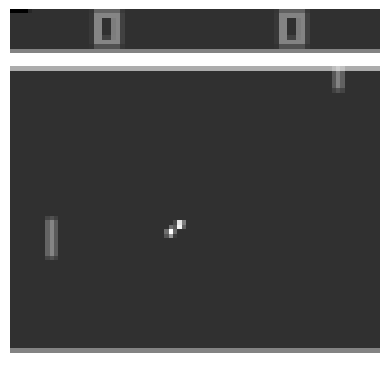

In [74]:
obs, info = env.reset()
display_frame(obs[-1], gray=True)

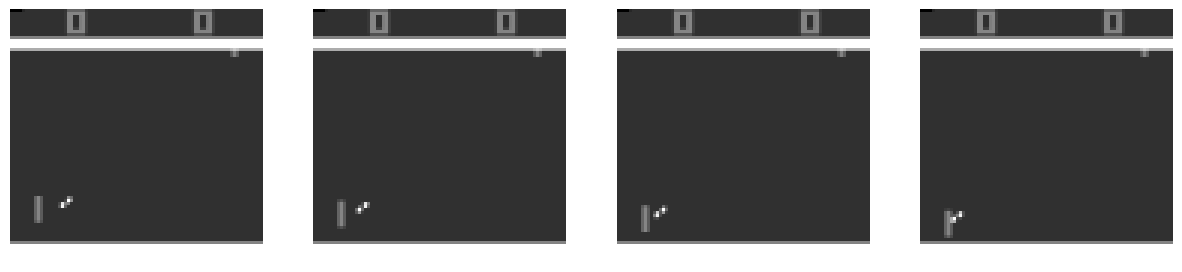

In [75]:
obs, info = env.reset()
display_multiple_frames(obs)

### Experience Replay 

In [ ]:
class ReplayBuffer:
    
    def __init__(self, capacity=10000) -> None:
        self.buffer = deque(maxlen=capacity)
        
    def store(self, experience: tuple) -> None:
        self.buffer.append(experience)
        
    def sample(self, batch_size) -> list:
        indices = np.random.randint(0, high=len(self), size=batch_size)
        return np.array([self[idx] for idx in indices])
        
    def __len__(self):
        return len(self.buffer)
    
    def __getitem__(self, index):
        return self.buffer[index]
    
    def __setitem__(self, index, value):
        self.buffer[index] = value
    
    def shuffle(self):
        np.random.shuffle(self.buffer)

In [77]:
NUM_EPS = 10
buffer_pong = ReplayBuffer()

for episode in range(NUM_EPS):
    done = False
    observation, _ = env.reset()
    step = 1
    
    next_state = [observation]
    
    while not done:
        action = env.action_space.sample()
        
        observation_prime, reward, terminated, truncated, _ = env.step(action)
        buffer_pong.store((observation[:, :, :, 0], action, reward, observation_prime[:, :, :, 0], terminated or truncated))
        observation = observation_prime
        
        done = terminated or truncated
        
print(len(buffer_pong))        

2176


(4, 84, 84)


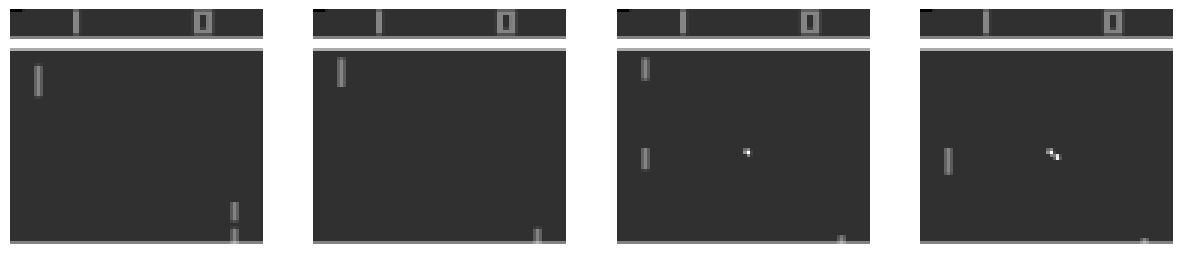

In [78]:
frame = buffer_pong[10][0]
print(frame.shape)
display_multiple_frames(frame)

In [ ]:
with open('replays/replay1.pkl', 'wb') as f:
    pickle.dump(buffer_pong, f)

In [154]:
class DQN(nn.Module):
    
    def __init__(
        self,
        env, 
        in_channels = 4, 
        num_actions = 6,
        hidden_filters = [16, 32], 
        start_epsilon = 0.99,
        max_decay = 0.1,
        decay_steps = 1000, 
        *args, 
        **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        
        self.start_epsilon = start_epsilon
        self.epsilon = start_epsilon
        self.max_decay = max_decay
        self.decay_steps = decay_steps
        self.env = env
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, hidden_filters[0], kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(hidden_filters[0], hidden_filters[1], kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(hidden_filters[1] * 9 * 9, 512),
            nn.ReLU(),
            nn.Linear(512, num_actions)
        )
        
    def forward(self, x):
        return self.layers(x)
     
    def epsilon_greedy(self, state, dim=1):
        q_values = self(state)
        rng = np.random.random()
        
        if rng < self.epsilon:
            action = self.env.action_space.sample()
        else:
            action = torch.argmax(q_values, dim=dim)
        
        return np.int64(action)
    
    def epsilon_decay(self, step):
        self.epsilon = self.max_decay + (self.start_epsilon - self.max_decay) * max(0, (self.decay_steps - step) / self.decay_steps)


In [ ]:
EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 32

q_network = DQN(env)
target_network = DQN(env)

optimizer = torch.optim.AdamW(q_network.parameters(), lr=LR)
